## <span style="color:red">Warning!</span> В ноутбуке используется ipywidgets, который не рендерится на GitHub

In [64]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [15]:
df = pd.read_csv("monthly-us-auto-registration-tho.csv", sep=';')

In [16]:
df.head()

,Month,Monthly U.S. auto registration (thousands) 1947 ? 1968
0,1947-01,209
1,1947-02,214
2,1947-03,265
3,1947-04,290
4,1947-05,287


In [17]:
series = df_auto['Monthly U.S. auto registration (thousands) 1947 ? 1968']

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


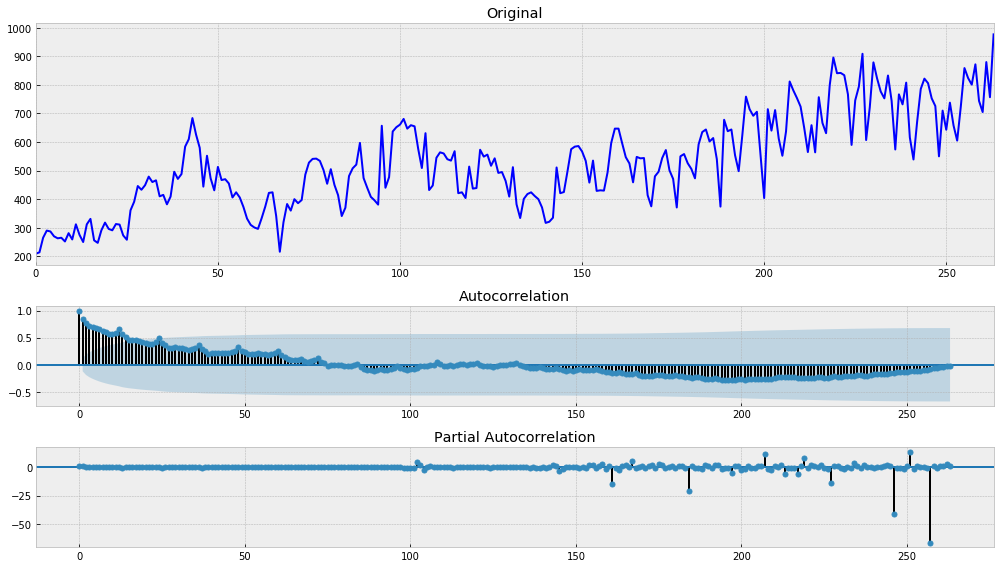

In [18]:
tsplot(series)

Изначальный ряд не является стационарным, приведем его к стационарности: применим перобразование Бокса-Кокса, продифференцируем, уберем сезонность

In [19]:
diff_series = np.diff(boxcox(series, 0), 1)

Results of Dickey-Fuller Test:
Test Statistic                -6.528275e+00
p-value                        1.001817e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


/mnt/c/linux-venv/nlp/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


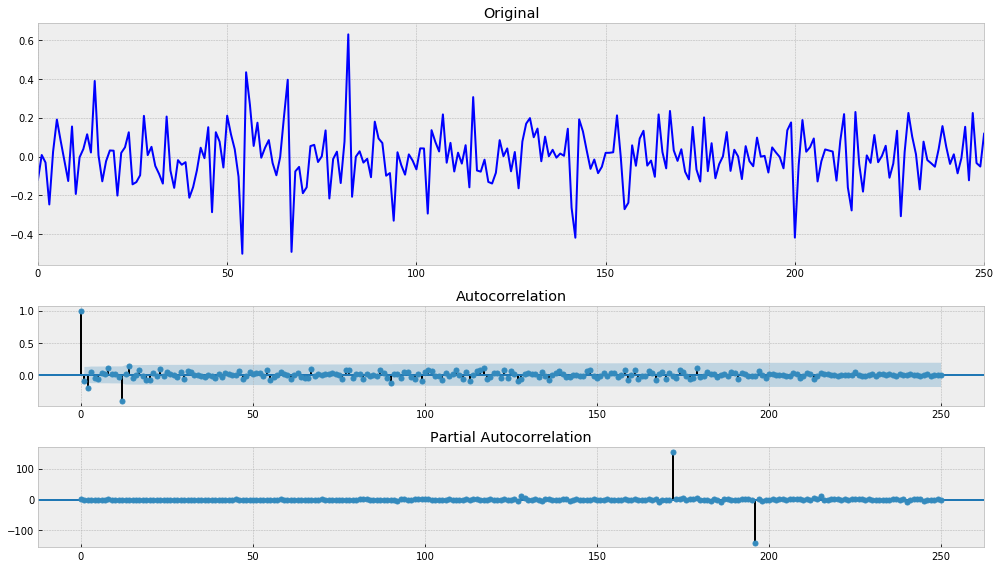

In [20]:
stat_series = diff_series[12:] - diff_series[:-12]
tsplot(stat_series)

Итак, у нас есть два ряда - стационарный и нестационарный, попробуем на них различные способы приближения

## Скользящее среднее

In [21]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

#### Скользящее среднее на нестационарном ряде

In [51]:
@interact
def moveing_average_test_non_stat(window=(3, 50, 1)):
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(series, color='blue',label='original')
        ser = moving_average(series, window)
        plt.plot(ser, color='red', linewidth='2', label=f'Moving Average {window}')
        plt.legend()    

interactive(children=(IntSlider(value=26, description='window', max=50, min=3), Output()), _dom_classes=('widg…

#### Скользящее среднее на стационарном ряде

In [52]:
@interact
def moveing_average_test_stat(window=(3, 50, 1)):
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(stat_series, color='blue',label='original')
        ser = moving_average(stat_series, window)
        plt.plot(ser, color='red', linewidth='2', label=f'Moving Average {window}')
        plt.legend()    

interactive(children=(IntSlider(value=26, description='window', max=50, min=3), Output()), _dom_classes=('widg…

На обоих рядах метод скользящего среднего показал неудовлетворительный результат.

На стационарном ряде скользящее среднее при большом окне вырождается практически в прямую, что логично. На нестационарном ряде получаем тренд.

## Взвешенное скользящее среднее

In [30]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

#### Взвешенное скользящее среднее на нестационарном ряде

In [55]:
@interact
def weighted_moving_average_test_non_stat(weigths=[('Фиббоначи', [1,1,2,3,5,8,13]), ('Последовательность', [1,2,3,4,5,6,7]), ('Степени двойки', [1,2,4,8,16,32,64])]):
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(series, color='blue',label='original')

        plt.plot(weighted_moving_average(series, 7, weigths), color='red', linewidth='2', label='WMA')
        plt.legend()

interactive(children=(Dropdown(description='weigths', options=(('Фиббоначи', [1, 1, 2, 3, 5, 8, 13]), ('Послед…

#### Взвешенное скользящее среднее на стационарном ряде

In [56]:
@interact
def weighted_moving_average_test_stat(weigths=[('Фиббоначи', [1,1,2,3,5,8,13]), ('Последовательность', [1,2,3,4,5,6,7]), ('Степени двойки', [1,2,4,8,16,32,64])]):
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(stat_series, color='blue',label='original')

        plt.plot(weighted_moving_average(stat_series, 7, weigths), color='red', linewidth='2', label='WMA')
        plt.legend()

interactive(children=(Dropdown(description='weigths', options=(('Фиббоначи', [1, 1, 2, 3, 5, 8, 13]), ('Послед…

Взвешенное скользящее среднее дает заметно лучший результат, чем просто скользящее среднее. Наилучшими параметрами для взвешенного скользящего среднего оказались степени двойки.

## Экспоненциальное сглаживание

In [38]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

#### Экспоненциальное сглаживание не нестационарном ряде

In [62]:
@interact
def exponential_moving_average_test_non_stat(alpha=(0, 1, 0.05)):
    ema = exponential_moving_average(series, alpha)
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(ema, color='red', linewidth='2', label='EMA')
        plt.legend()

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

#### Экспоненциальное сглаживание не нестационарном ряде

In [63]:
@interact
def exponential_moving_average_test_stat(alpha=(0, 1, 0.05)):
    ema = exponential_moving_average(stat_series, alpha)
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(stat_series, color='blue',label='original')
        plt.plot(ema, color='red', linewidth='2', label='EMA')
        plt.legend()

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), Output()), _dom_classes…

При $\alpha$, близких к 1 выдает последовательности, близкие к исходным (что логично). А при значениях, близких к нулю (но не ноль) - показывает тренд. Но, как мы знаем, экспоненциальное сглаживаение плохо подходит для прогнозов - происходит быстрое вырождение в прямую.

## Двойное экспоненциальное сглаживание

In [58]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

#### Двойное экспоненциальное сглаживание на нестационарном ряде

In [60]:
@interact
def double_ema_test_non_stat(alpha=(0, 1, 0.05), beta=(0, 1, 0.05)):
    dema = double_ema(series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), FloatSlider(value=0.0, …

#### Двойное экспоненциальное сглаживание на стационарном ряде

In [61]:
@interact
def double_ema_test_stat(alpha=(0, 1, 0.05), beta=(0, 1, 0.05)):
    dema = double_ema(stat_series, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(stat_series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), FloatSlider(value=0.0, …

Различные параметры дают крайне разные результаты - попробуем подобрать параметры, которые будут давать хорошее предсказание.

#### Подбираем параметры для нестационарного ряда

In [108]:
train_nstat, val_nstat = series[:210], series[210:]

In [109]:
def double_ema_forecast(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True)

In [182]:
def dema_mse_cross_val_nstat(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train_nstat):
        result = double_ema_forecast(pd.Series(train_split), alpha, beta, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [183]:
opt_dema_nstat = minimize(dema_mse_cross_val_nstat, x0=[0.0,0.0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [184]:
alpha_opt_dema_nstat, beta_opt_dema_nstat = opt_dema_nstat.x
opt_dema_nstat

      fun: 0.9999999999991385
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00014473, 0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 1
   status: 0
  success: True
        x: array([4.5637533e-06, 0.0000000e+00])

In [152]:
def plot_dema(alpha, beta, ser, ser_to_plot, n_preds):
    dema = double_ema_forecast(pd.Series(ser), alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='2', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

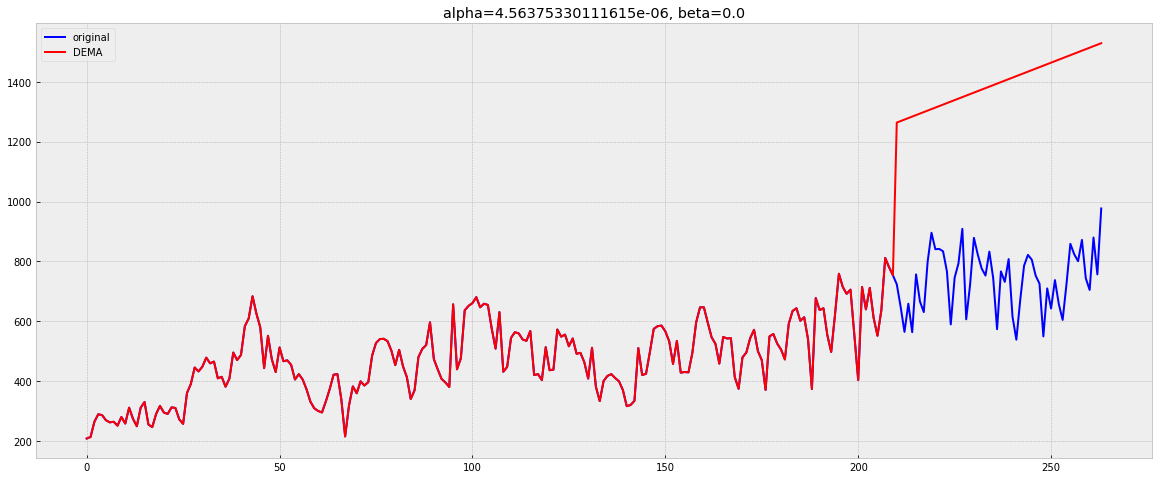

In [153]:
plot_dema(alpha_opt_dema_nstat, beta_opt_dema_nstat, train_nstat, series, len(val_nstat))

Нестационарный ряд предсказывается никак. Попробуем вручную.

In [174]:
@interact
def dema_test_nstat_pred(alpha=(0, 1, 0.05), beta=(0, 1, 0.05)):
    plot_dema(alpha, beta, train_nstat, series, len(val_nstat))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), FloatSlider(value=0.0, …

С моей точки зрения, наилучший результат получается при $\alpha$=0.05 и $\beta$=0.75

#### Подбираем параметры для стационарного ряда

In [143]:
train_stat, val_stat = stat_series[:200], stat_series[200:]

In [176]:
def dema_mse_cross_val_stat(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train_stat):
        result = double_ema_forecast(pd.Series(train_split), alpha, beta, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [177]:
opt_dema_stat = minimize(dema_mse_cross_val_stat, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [178]:
alpha_opt_dema_stat, beta_opt_dema_stat = opt_dema_stat.x
opt_dema_stat

      fun: 0.999999999999759
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([7.49067475e-05, 0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 15
      nit: 1
   status: 0
  success: True
        x: array([8.9084295e-07, 0.0000000e+00])

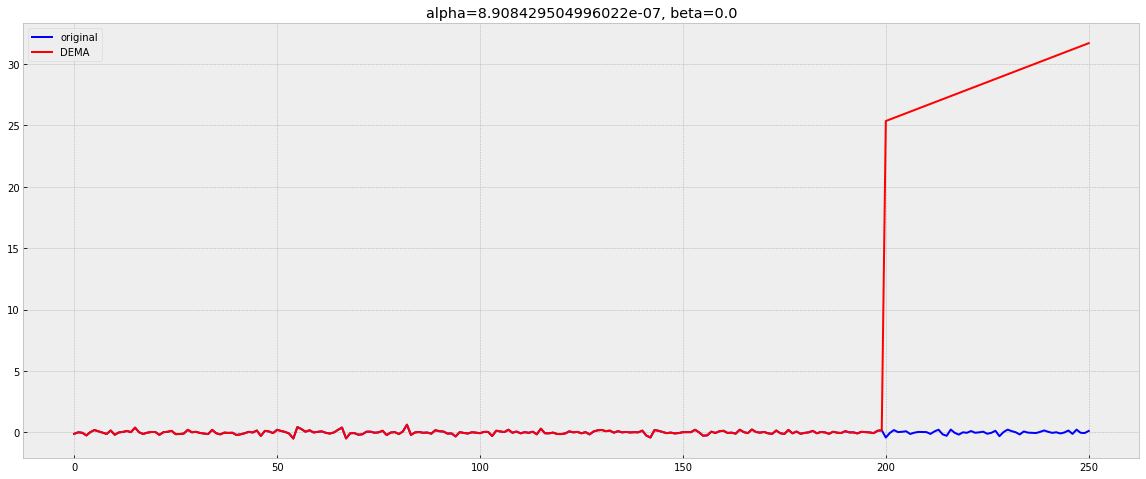

In [179]:
plot_dema(alpha_opt_dema_stat, beta_opt_dema_stat, train_stat, stat_series, len(val_stat))

Со стационарным рядом тоже получается как-то неудобно. Тут тоже попробуем руками подобрать.

In [171]:
@interact
def dema_test_stat_pred(alpha=(0, 1, 0.05), beta=(0, 1, 0.05)):
    plot_dema(alpha, beta, train_stat, stat_series, len(val_stat))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), FloatSlider(value=0.0, …

С моей точки зрения, наилучший результат получается при $\alpha$=0.05 и $\beta$=0.25. Хотя прямая вместо колебаний - сомнительное решение.

## Хольт-Винтерс

In [166]:
def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(series[i+season_len] - series[i]) / season_len
    return sum / season_len

In [156]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [157]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [158]:
def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='2', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

#### Хольт-Винтерс для нестационарного ряда

In [175]:
@interact
def tema_test_nstat_pred(alpha=(0, 1, 0.05), beta=(0, 1, 0.05), gamma=(0, 1, 0.05)):
    plot_tema(alpha, beta, gamma, train_nstat, series, len(val_nstat))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), FloatSlider(value=0.0, …

Пробуем подобрать параметры.

In [194]:
def tema_mse_cross_val_nstat(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train_nstat):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [188]:
opt_tema_nstat = minimize(tema_mse_cross_val_nstat, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [189]:
alpha_opt_tema_nstat, beta_opt_tema_nstat, gamma_opt_tema_nstat = opt_tema_nstat.x
print(opt_tema_nstat)

      fun: 0.0
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.68257963e-19, 0.00000000e+00, 0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([0., 0., 1.])


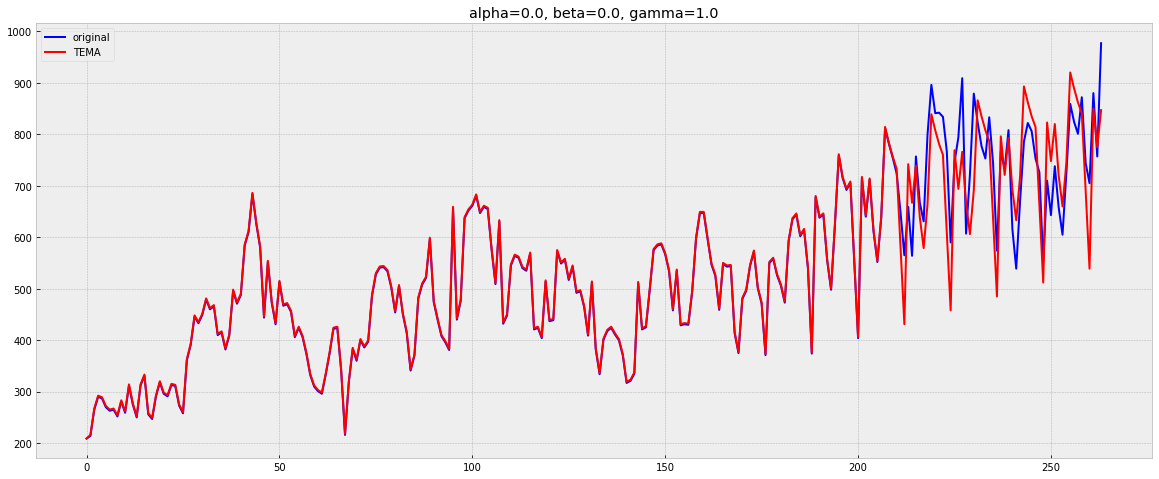

In [190]:
plot_tema(alpha_opt_tema_nstat, beta_opt_tema_nstat, gamma_opt_tema_nstat, train_nstat, series, len(val_nstat))

Не идеально, но значительно лучше, чем при двойном сглаживании. Причем, параметры находятся в граничных значениях...

#### Хольт-Винтерс для стационарного ряда
Вообще, данный метод не применяют к рядам с убранной сезонностью, но мы попробуем

In [191]:
@interact
def tema_test_stat_pred(alpha=(0, 1, 0.05), beta=(0, 1, 0.05), gamma=(0, 1, 0.05)):
    plot_tema(alpha, beta, gamma, train_stat, stat_series, len(val_stat))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), FloatSlider(value=0.0, …

Пробуем подобрать параметры.

In [195]:
def tema_mse_cross_val_stat(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train_stat):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [196]:
opt_tema_stat = minimize(tema_mse_cross_val_stat, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [197]:
alpha_opt_tema_stat, beta_opt_tema_stat, gamma_opt_tema_stat = opt_tema_stat.x
print(opt_tema_stat)

      fun: 4.780381511774906e-08
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.59756646e-06, -5.08011008e-08,  2.21516080e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 72
      nit: 17
   status: 0
  success: True
        x: array([0.04603814, 0.        , 0.98267948])


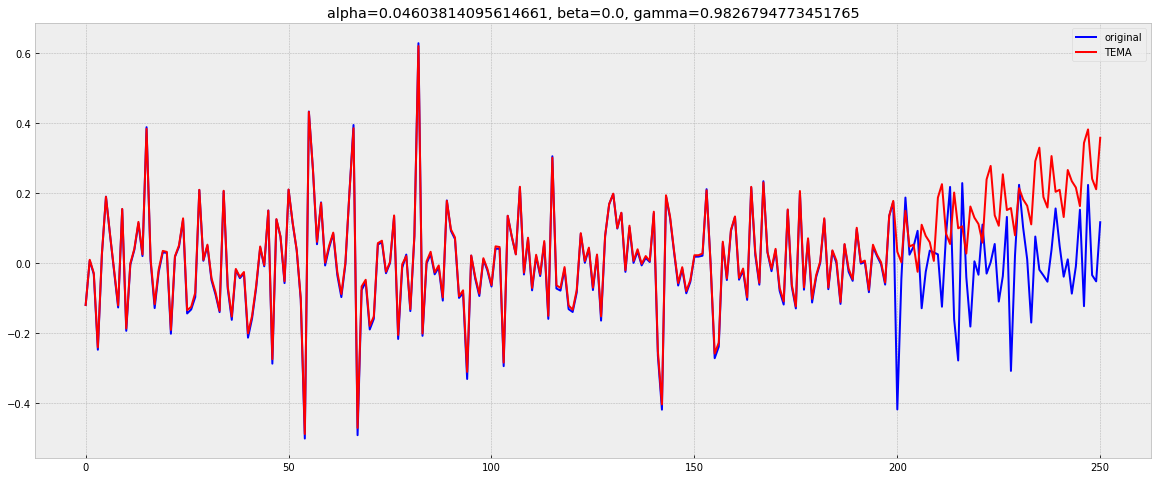

In [198]:
plot_tema(alpha_opt_tema_stat, beta_opt_tema_stat, gamma_opt_tema_stat, train_stat, stat_series, len(val_stat))

Как и ожидалось, здесь результат значительно хуже, чем для нестационарного ряда.

#### Bonus

Попробуем применить данный метод к ряду после Бокса-Кокса и дифференциация, но без убирания сезонности

In [200]:
len(diff_series)
train_bonus, val_bonus = diff_series[:210], diff_series[210:]

In [201]:
@interact
def tema_test_bonus_pred(alpha=(0, 1, 0.05), beta=(0, 1, 0.05), gamma=(0, 1, 0.05)):
    plot_tema(alpha, beta, gamma, train_bonus, diff_series, len(val_bonus))

interactive(children=(FloatSlider(value=0.0, description='alpha', max=1.0, step=0.05), FloatSlider(value=0.0, …

In [202]:
def tema_mse_cross_val_bonus(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train_bonus):
        result = triple_exponential_smoothing(train_split, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        error = mean_squared_error(predictions, test_split)
        errors.append(error)

    return np.mean(np.array(errors))

In [203]:
opt_tema_bonus = minimize(tema_mse_cross_val_bonus, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [204]:
alpha_opt_tema_bonus, beta_opt_tema_bonus, gamma_opt_tema_bonus = opt_tema_bonus.x
print(opt_tema_bonus)

      fun: 0.0
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.68257963e-19, 0.00000000e+00, 0.00000000e+00])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([0., 0., 1.])


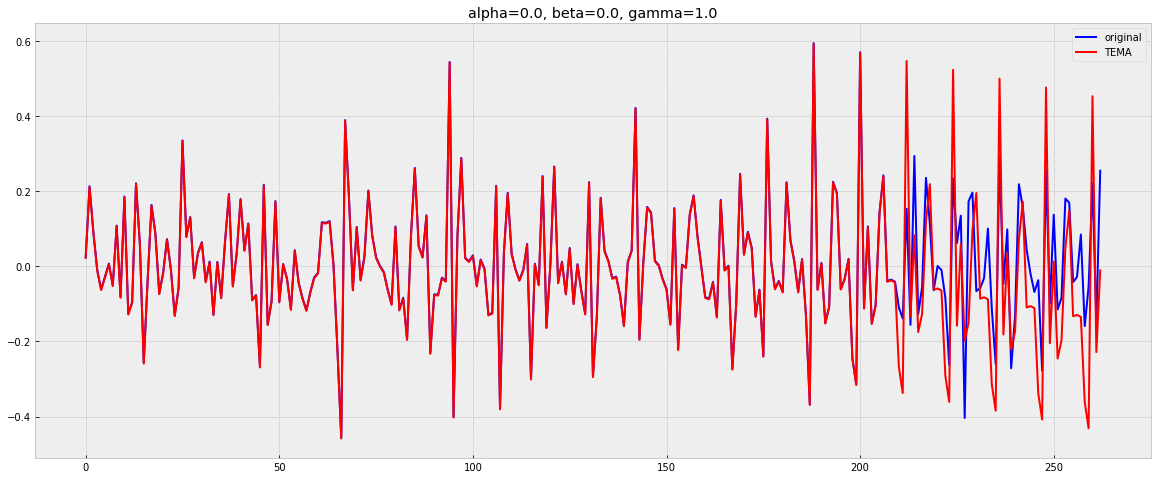

In [205]:
plot_tema(alpha_opt_tema_bonus, beta_opt_tema_bonus, gamma_opt_tema_bonus, train_bonus, diff_series, len(val_bonus))

Результат лучше, чем после избавления от сезонности, но хуже, чем для исходного ряда.

В качестве вывода можно сказать, что лучше всего для предсказания использовать метод Хольта-Винтерса, причем на исходном графике.